# Identifying ASL letters from images using ResNet9 deep learning architecture and PyTorch

## Deep learning is useful for gathering insights from unstructured data, like images. This project is preparation for building live ASL interpretation of letters, and eventually words, through the OpenCV computer vision library. I performed single label classification using PyTorch and ResNet9 architecture to achieve a model accuracy of 99%.

#### Scope:
#### - Select and import dataset
#### - Prepare dataset
#### - Move dataset to GPU
#### - Define deep learning model (neural network)
#### - Train model
#### - Test predictions and adjust hyperparameters 

# Select and import data

`opendatasets` allows Kaggle imports directly from Kaggle, without needing to download to local computer.

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
import os

In [ ]:
dataset_url = 'https://www.kaggle.com/grassknoted/asl-alphabet'

Delete directory if it already exists in the workspace, before importing it

In [ ]:
import shutil

if os.path.exists('./asl-alphabet'):
  shutil.rmtree('./asl-alphabet')

In [ ]:
od.download(dataset_url)

  1%|          | 11.0M/1.03G [00:00<00:09, 114MB/s]

100%|██████████| 1.03G/1.03G [00:04<00:00, 238MB/s]


Import dataset into Pytorch
using 'ImageFolder' class from 'torchvision' to parse structure

In [ ]:
data_dir = './asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [ ]:
os.listdir(data_dir)

['nothing',
 'W',
 'R',
 'V',
 'X',
 'M',
 'O',
 'J',
 'A',
 'U',
 'T',
 'S',
 'H',
 'K',
 'I',
 'B',
 'D',
 'L',
 'E',
 'Q',
 'P',
 'G',
 'Z',
 'del',
 'space',
 'F',
 'C',
 'N',
 'Y']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

nothing : 3000
W : 3000
R : 3000
V : 3000
X : 3000
M : 3000
O : 3000
J : 3000
A : 3000
U : 3000
T : 3000
S : 3000
H : 3000
K : 3000
I : 3000
B : 3000
D : 3000
L : 3000
E : 3000
Q : 3000
P : 3000
G : 3000
Z : 3000
del : 3000
space : 3000
F : 3000
C : 3000
N : 3000
Y : 3000


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

87000

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=200x200 at 0x7F7D5A1B3490>, 0)

In [ ]:
dataset.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Peek a data point or two

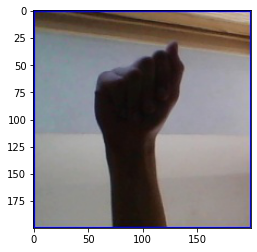

In [ ]:
img, label = dataset[0]
plt.imshow(img)

# Prepare dataset

Create tensors of the images to pass through the model. 

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

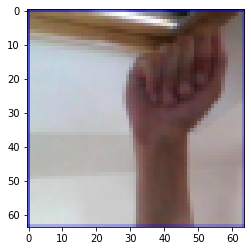

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

Decide how to split validation and training data

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size 

train_size, val_size

(78300, 8700)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(78300, 8700)

Create data loaders to work with data in batches (batches should fit neatly into memory, e.g. 128, 256, etc)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

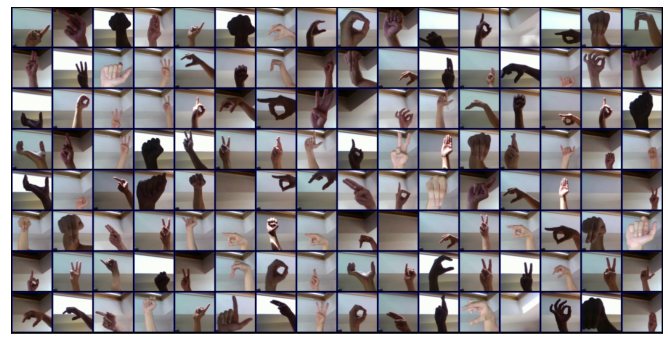

In [ ]:
show_batch(train_dl)

# Move dataset to GPU

Helper functions to move data onto GPU (necessary when working with tensors)

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.shape

torch.Size([3, 64, 64])

In [ ]:
img.device

device(type='cpu')

We see that the images are currently being processed on the CPU, so we want to send them to the GPU instead

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Define deep learning model

We are performing single-label classification. We now need to create code for the actual image classification.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Now to create the model. We'll use ResNet9 by David Page. ResNet architecture is explained [here](https://en.wikipedia.org/wiki/Residual_neural_network) and [here]( https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #conv_blocks halve the final two inputs
        #pool=True doubles the second input
        # Feature map input: 128 x 3 x 64 x 64 (last two numbers are pixel dimensions)
        self.conv1 = conv_block(in_channels, 64) #Output: 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) #Output: 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), #Output: 128 x 128 x 32 x 32
                                  conv_block(128, 128)) #Output: 128 x 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) #Output: 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) #Output: 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), #Output: 128 x 512 x 8 x 8
                                  conv_block(512, 512)) #Output: 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), #Output: 128 x 512 x 1 x 1 (combines pixels into 2d argument) 
                                        nn.Flatten(), #Output: 128 x 512 (because 2 x 2 flattened is 4 x 512 from last line)
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Always pass one batch of input tensors through the model to make sure it's set up correctly. Better to verify in advance than get an error and spend time in confusion. If working with a GPU, make sure images are actually running on the GPU. Deep learning modeling involves a lot of small, defensive testing ahead of time.

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  print(preds)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 29])
tensor([[-1.5208, -4.9593, -0.7440,  ..., -0.5131, -3.4937, -3.9255],
        [ 0.8448, -5.4021, -0.7830,  ..., -1.6367, -0.7587, -4.9431],
        [ 0.3805, -3.6455,  0.3274,  ...,  1.6919, -1.6504, -4.7193],
        ...,
        [ 1.4430, -3.4911,  0.9122,  ..., -0.0548, -1.4035, -2.7460],
        [ 0.7973, -2.5943, -0.2367,  ...,  0.4451, -1.2359, -3.3051],
        [-1.7532, -4.1467, -0.3851,  ..., -0.1489,  1.4148, -6.4686]],
       device='cuda:0', grad_fn=<AddmmBackward>)


`preds.shape` above shows that for each image, we get 29 probabilities for prediction class. Whichever output has the highest magnitude is the model's prediction.


# Train model

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.03471522033214569, 'val_loss': 3.3681960105895996}]

Set hyperparameters

In [ ]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5000, val_loss: 0.0761, val_acc: 0.9759
Epoch [1], train_loss: 0.0184, val_loss: 0.0295, val_acc: 0.9905
Epoch [2], train_loss: 0.0151, val_loss: 0.0180, val_acc: 0.9945
Epoch [3], train_loss: 0.0123, val_loss: 0.0032, val_acc: 0.9990
Epoch [4], train_loss: 0.0101, val_loss: 0.0060, val_acc: 0.9979


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs number of epochs')

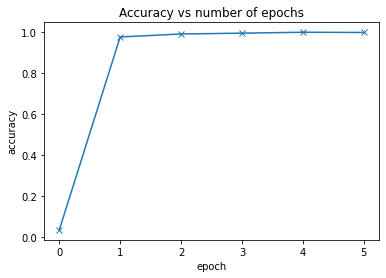

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. number of epochs');

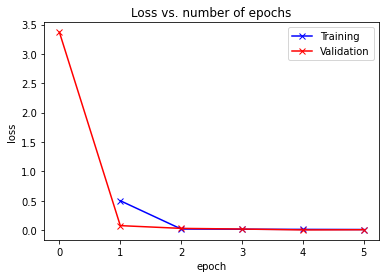

In [ ]:
plot_losses(history)

Overfitting occurs when validation loss starts to increase. From the above graph, the model does not seem to be overfit.

Results:

Initial evaluation returned 3.7% accuracy. Final accuracy was 99.38%, for a roughly 95% improvement.

Hyperparameters summary:

The model ingested a dataset of 64x64 pixel images from [Kaggle](https://www.kaggle.com/grassknoted/asl-alphabet), with a batch size of 128, using ResNet9 architecture and the Adam optimizer. The data was passed through 5 epochs with a learning rate of 0.001.

In [ ]:
history[-1]

{'train_loss': 0.010057685896754265,
 'val_acc': 0.997928261756897,
 'val_loss': 0.006011438090354204}

# Test predictions and adjust hyperparameters

Final testing


In [ ]:
def predict_image(img, model, classes):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return classes[preds[0].item()]

In [ ]:
def show_prediction(img, label):
  plt.imshow(img.permute((1, 2, 0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)

Target: H
Prediction: H


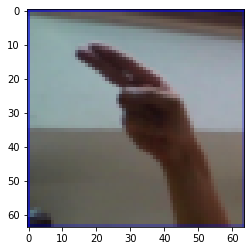

In [ ]:
show_prediction(*valid_ds[20])

Target: L
Prediction: L


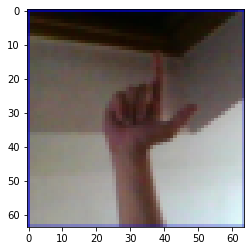

In [ ]:
show_prediction(*valid_ds[300])

Target: N
Prediction: N


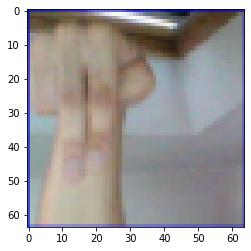

In [ ]:
show_prediction(*valid_ds[7001])

In [ ]:
torch.save(model.state_dict(), 'asl_resnet9.pth')

Hooray! Time to eat some pasta :)